# Rewards and Utilities

The key distinction between control theory and reinforcement learning (RL) lies in the challenge of determining optimal actions without prior knowledge of what constitutes an optimal action. This contrasts with supervised learning, where we typically have access to a dataset of input-output pairs from an unknown mapping that we aim to approximate. While historical data might be available in RL, it often provides only indirect information about the right action to take in any given situation. This weaker form of supervisory feedback is typically provided via a reward function, which indicates the degree of adequacy for an action in the immediate situation. The reward function need not carry information about the long-term adequacy of an action towards achieving a more general objective, nor does it dictate the right action to take directly.

One might ask why we don't simply ask experts to provide this information more directly; that is, to provide examples of the right actions to choose in a given situation, hoping to generalize beyond those examples. While conceptually similar to supervised learning, this approach, called imitation learning (IL), still faces significant challenges as it offloads the burden of providing optimal solutions onto the expert. The complexity arises because we aim to find sequences of actions that maximize some long-term function of the rewards encountered along the way. Our decisions are rarely myopic, and it's this need for foresight in selecting actions that makes the problem challenging. Furthermore, significant challenges arise regarding whether the collected data is representative of the distribution of our current policy. This makes IL inherently bound to the challenge of out-of-distribution (OOD) generalization.

If providing examples of optimal actions is too difficult, it might be easier to let an algorithm search for those optimal actions while only specifying the goal that the system should achieve by defining a reward function. However, there are also instances where specifying the reward function itself could be a daunting task. The challenge lies in the fact that goals and objectives are usually temporally extended in nature, and that the consequences of actions compound through time, making it difficult to determine in advance the effect of local reward feedback on the overall solution found by the system.

## What is a good policy? 

The overall objective is clear: given access to data, we aim to determine the right actions or decisions to take in any given situation. However, to transform this aspiration into a concrete framework, we need to convert the notion of what constitutes a good way of acting—a policy—into an actionable definition. Furthermore, the adequacy of a policy is also a function of how it will be used—the environment to which it applies.

This course considers two broad categories of environments, each with its own specialized solution methods: deterministic and stochastic environments. Stochastic problems are mathematically more general than their deterministic counterparts, hence we begin our presentation with this setting. However, despite this generality, it's important to note that algorithms for stochastic problems are not necessarily more powerful than those designed for deterministic ones when used in practice.

Stochasticity and determinism are assumed properties of the world, which we model—perhaps imperfectly—into our algorithms. Consequently, mathematical expressivity need not correlate with the empirical performance of a method. This is a lesson our field is increasingly embracing with the advent of deep learning and large language models.

Seeking a good, adequate, performing, or optimal policy implies a notion of comparison: good compared to what? This necessitates a concept of ordering or ranking alternatives or choices from which one can select. Hence, a logical starting point for our grounding lies in the notion of stochastic ordering in probability theory.

A scalar-valued random variable $U$ is said to be stochastically greater than another random variable $V$ if:

$$
Pr[U > x] \geq Pr[V > x]
$$

for all $x \in \mathbb{R}$.

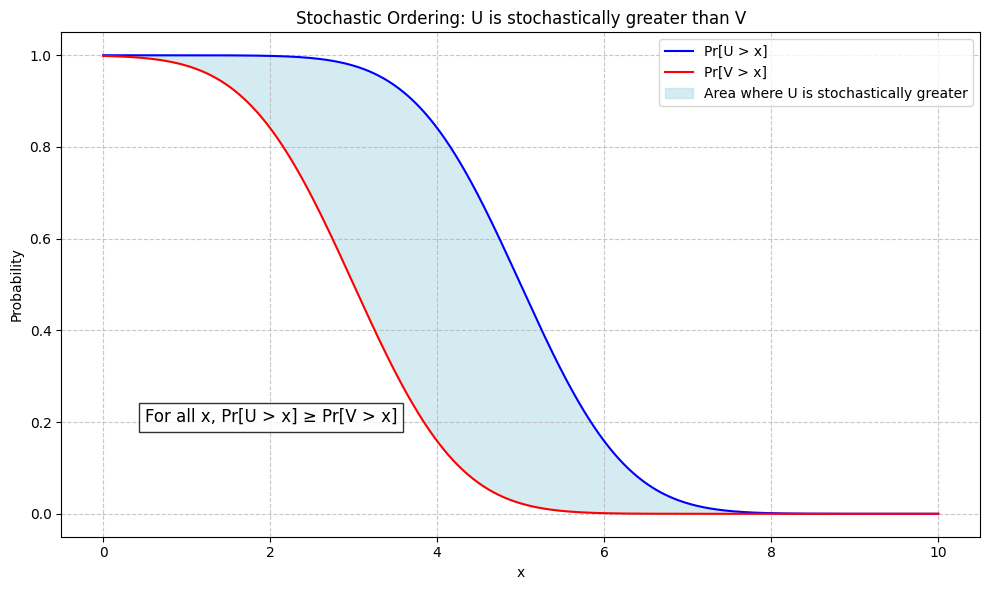

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Set random seed for reproducibility
np.random.seed(42)

# Generate two different normal distributions
mu1, sigma1 = 5, 1  # Mean and standard deviation for U
mu2, sigma2 = 3, 1  # Mean and standard deviation for V

# Create x values
x = np.linspace(0, 10, 1000)

# Calculate CDFs
cdf_U = stats.norm.cdf(x, mu1, sigma1)
cdf_V = stats.norm.cdf(x, mu2, sigma2)

# Calculate complementary CDFs (1 - CDF)
ccdf_U = 1 - cdf_U
ccdf_V = 1 - cdf_V

# Create the plot
plt.figure(figsize=(10, 6))

# Plot complementary CDFs
plt.plot(x, ccdf_U, label='Pr[U > x]', color='blue')
plt.plot(x, ccdf_V, label='Pr[V > x]', color='red')

# Fill the area where U is stochastically greater
plt.fill_between(x, ccdf_U, ccdf_V, where=(ccdf_U >= ccdf_V), 
                 color='lightblue', alpha=0.5, 
                 label='Area where U is stochastically greater')

plt.title('Stochastic Ordering: U is stochastically greater than V')
plt.xlabel('x')
plt.ylabel('Probability')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# Add text explanation
plt.text(0.5, 0.2, 'For all x, Pr[U > x] ≥ Pr[V > x]', 
         fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

We can generalize the above definition to multivariate random variables by taking the expectation over the components and requiring that for any function $f$ which preserve the partial ordering

$$
\mathbb{E}\left[f\left(\mathbf{V}\right)\right] \leq \mathbb{E}\left[f\left(\mathbf{U}\right)\right]
$$
for all $f: \mathbb{R}^n \rightarrow \mathbb{R}$. We say then say that $U$ is stochastically greather than $V$. 

<!-- $v_i \leq u_i$ for $i=1, \ldots, N ; f\left(v_1, \ldots, v_N\right) \leq f\left(u_1, \ldots, u_N\right)$ -->

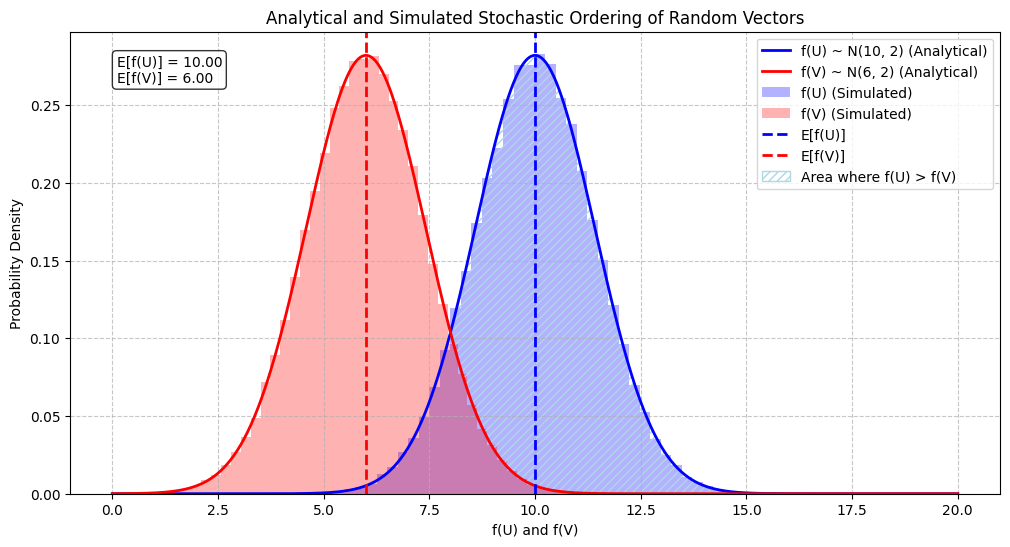

Analytical E[f(U)] = 10.0000
Analytical E[f(V)] = 6.0000
Simulated E[f(U)] = 10.0019
Simulated E[f(V)] = 5.9984
E[f(U)] > E[f(V)]: True


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Parameters
mu_U, sigma_U = 5, 1
mu_V, sigma_V = 3, 1
n_samples = 100000

# Analytical results
mu_f_U = 2 * mu_U
sigma_f_U = np.sqrt(2 * sigma_U**2)
mu_f_V = 2 * mu_V
sigma_f_V = np.sqrt(2 * sigma_V**2)

# Generate random samples
np.random.seed(42)
U1 = np.random.normal(mu_U, sigma_U, n_samples)
U2 = np.random.normal(mu_U, sigma_U, n_samples)
V1 = np.random.normal(mu_V, sigma_V, n_samples)
V2 = np.random.normal(mu_V, sigma_V, n_samples)

# Calculate f(U) and f(V)
f_U = U1 + U2
f_V = V1 + V2

# Create x values for plotting
x = np.linspace(0, 20, 1000)

# Calculate PDFs
pdf_f_U = stats.norm.pdf(x, mu_f_U, sigma_f_U)
pdf_f_V = stats.norm.pdf(x, mu_f_V, sigma_f_V)

# Plotting
plt.figure(figsize=(12, 6))

# Plot analytical PDFs
plt.plot(x, pdf_f_U, label='f(U) ~ N(10, 2) (Analytical)', color='blue', linewidth=2)
plt.plot(x, pdf_f_V, label='f(V) ~ N(6, 2) (Analytical)', color='red', linewidth=2)

# Plot histograms
plt.hist(f_U, bins=50, density=True, alpha=0.3, color='blue', label='f(U) (Simulated)')
plt.hist(f_V, bins=50, density=True, alpha=0.3, color='red', label='f(V) (Simulated)')

plt.axvline(mu_f_U, color='blue', linestyle='dashed', linewidth=2, label='E[f(U)]')
plt.axvline(mu_f_V, color='red', linestyle='dashed', linewidth=2, label='E[f(V)]')

plt.title('Analytical and Simulated Stochastic Ordering of Random Vectors')
plt.xlabel('f(U) and f(V)')
plt.ylabel('Probability Density')

plt.text(0.05, 0.95, f'E[f(U)] = {mu_f_U:.2f}\nE[f(V)] = {mu_f_V:.2f}', 
         transform=plt.gca().transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Fill the area where f(U) > f(V) with hatched pattern
intersection = np.roots([1/(2*sigma_f_U**2) - 1/(2*sigma_f_V**2),
                         -2*mu_f_U/(2*sigma_f_U**2) + 2*mu_f_V/(2*sigma_f_V**2),
                         mu_f_U**2/(2*sigma_f_U**2) - mu_f_V**2/(2*sigma_f_V**2) - np.log(sigma_f_U/sigma_f_V)])
intersection = intersection[np.isreal(intersection)].real
if len(intersection) > 0:
    plt.fill_between(x[x > intersection[0]], pdf_f_U[x > intersection[0]], pdf_f_V[x > intersection[0]], 
                     facecolor="none", hatch="////", edgecolor="lightblue", label='Area where f(U) > f(V)')

plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

print(f"Analytical E[f(U)] = {mu_f_U:.4f}")
print(f"Analytical E[f(V)] = {mu_f_V:.4f}")
print(f"Simulated E[f(U)] = {np.mean(f_U):.4f}")
print(f"Simulated E[f(V)] = {np.mean(f_V):.4f}")
print(f"E[f(U)] > E[f(V)]: {mu_f_U > mu_f_V}")